<a href="https://colab.research.google.com/github/Aakankshadhidhi069/VerifyPro/blob/main/carobjdetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os, time, random
import PIL
import numpy as np
import pandas as pd
import cv2, torch
from tqdm.auto import tqdm
import shutil as sh

from IPython.display import Image, clear_output
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pathlib
img_h, img_w, num_channels = (380, 676, 3)
path = "/content/drive/MyDrive/carobjectdetection/data/train_solution_bounding_boxes (1).csv"
path2 = "/content/drive/MyDrive/carobjectdetection/data/training_images"
path3 = "/content/drive/MyDrive/Colab Notebooks/train_solution_bounding_boxes (1).csv"
df1 = pathlib.Path(path3)
df = pd.read_csv(path3,engine = 'python')
df.rename(columns={'image':'image_id'}, inplace=True)
df['image_id'] = df['image_id'].apply(lambda x: x.split('.')[0])
df['x_center'] = (df['xmin'] + df['xmax'])/2
df['y_center'] = (df['ymin'] + df['ymax'])/2
df['w'] = df['xmax'] - df['xmin']
df['h'] = df['ymax'] - df['ymin']
df['classes'] = 0
df['x_center'] = df['x_center']/img_w
df['w'] = df['w']/img_w
df['y_center'] = df['y_center']/img_h
df['h'] = df['h']/img_h
df.head()

,image_id,xmin,ymin,xmax,ymax,x_center,y_center,w,h,classes
0,vid_4_1000,281.259045,187.035071,327.727931,223.225547,0.450434,0.539817,0.068741,0.095238,0
1,vid_4_10000,15.163531,187.035071,120.329957,236.430180,0.100217,0.557191,0.155572,0.129987,0
2,vid_4_10040,239.192475,176.764800,361.968162,236.430180,0.444645,0.543678,0.181621,0.157014,0
3,vid_4_10020,496.483358,172.363256,630.020261,231.539575,0.833213,0.531451,0.197540,0.155727,0
4,vid_4_10060,16.630970,186.546010,132.558611,238.386422,0.110347,0.559122,0.171491,0.136422,0


In [ ]:
from google.colab.patches import cv2_imshow
index = list(set(df.image_id))
image = random.choice(index)
print("Image ID: %s"%(image))
img = cv2.imread(f'/content/drive/MyDrive/carobjectdetection/data/training_images/{image}.jpg')
img.shape

Image ID: vid_4_2520


(380, 676, 3)

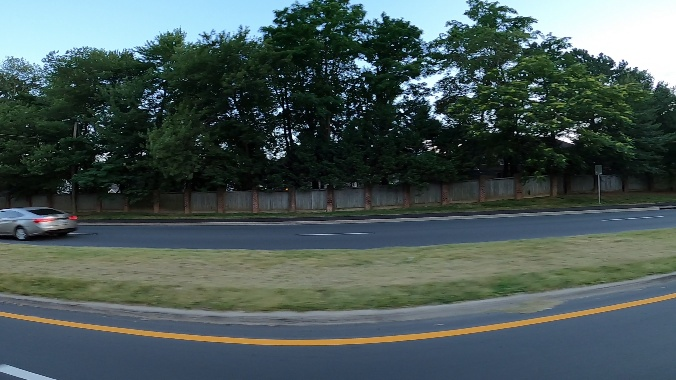

In [ ]:
image = random.choice(index)
Image(filename=f'/content/drive/MyDrive/carobjectdetection/data/training_images/{image}.jpg',width=600)

In [ ]:
source = 'training_images'
if True:
    for fold in [0]:
        val_index = index[len(index)*fold//5:len(index)*(fold+1)//5]
        for name,mini in tqdm(df.groupby('image_id')):
            if name in val_index:
                path2save = 'val2017/'
            else:
                path2save = 'train2017/'
            if not os.path.exists('/tmp/convertor/fold{}/labels/'.format(fold)+path2save):
                os.makedirs('/tmp/convertor/fold{}/labels/'.format(fold)+path2save)
            with open('/tmp/convertor/fold{}/labels/'.format(fold)+path2save+name+".txt", 'w+') as f:
                row = mini[['classes','x_center','y_center','w','h']].astype(float).values
                row = row.astype(str)
                for j in range(len(row)):
                    text = ' '.join(row[j])
                    f.write(text)
                    f.write("\n")
            if not os.path.exists('/tmp/convertor/fold{}/images/{}'.format(fold,path2save)):
                os.makedirs('/tmp/convertor/fold{}/images/{}'.format(fold,path2save))
            sh.copy("/content/drive/MyDrive/carobjectdetection/data/{}/{}.jpg".format(source,name),'/tmp/convertor/fold{}/images/{}/{}.jpg'.format(fold,path2save,name))

In [ ]:
#!python train.py --batch 2 --epochs 1 --data ../input/yolov5-config/car.yaml --cfg ../input/yolov5-config/yolov5x.yaml --name yolov5x_fold0_new

In [ ]:
!git clone https://github.com/ultralytics/yolov5  # clone repo
%cd yolov5
%pip install -qr requirements.txt  # install dependencies

import torch
from IPython.display import Image, clear_output  # to display images

clear_output()
print(f"Setup complete. Using torch {torch.__version__} ({torch.cuda.get_device_properties(0).name if torch.cuda.is_available() else 'CPU'})")

Setup complete. Using torch 1.9.0+cu102 (Tesla T4)


In [ ]:
!python yolov5/detect.py --weights yolov5/yolov5s.pt --img 676 --conf 0.4 --source  /content/drive/MyDrive/carobjectdetection/data/testing_images

python3: can't open file 'yolov5/detect.py': [Errno 2] No such file or directory


In [ ]:
!python detect.py --weights yolov5s.pt --img 676 --conf 0.4 --source /content/drive/MyDrive/carobjectdetection/data/testing_images


detect: weights=['yolov5s.pt'], source=/content/drive/MyDrive/carobjectdetection/data/testing_images, imgsz=676, conf_thres=0.4, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False
YOLOv5 🚀 v5.0-280-g80299a5 torch 1.9.0+cu102 CUDA:0 (Tesla T4, 15109.75MB)

Fusing layers... 
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
Model Summary: 224 layers, 7266973 parameters, 0 gradients
ima

In [ ]:
predicted_files = []
for (dirpath, dirnames, filenames) in os.walk("runs/detect/exp"):
    predicted_files.extend(filenames)

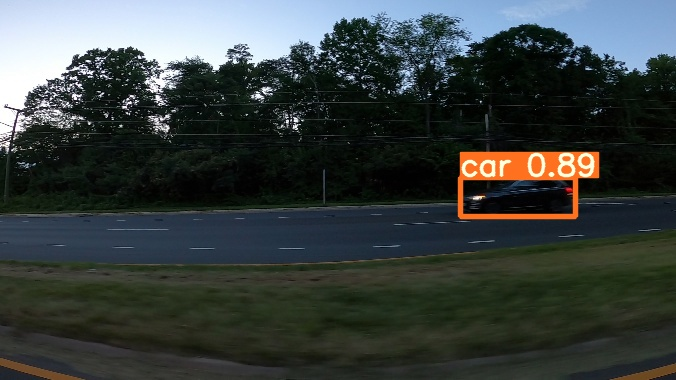

In [ ]:
Image(filename=f'runs/detect/exp/{random.choice(predicted_files)}')

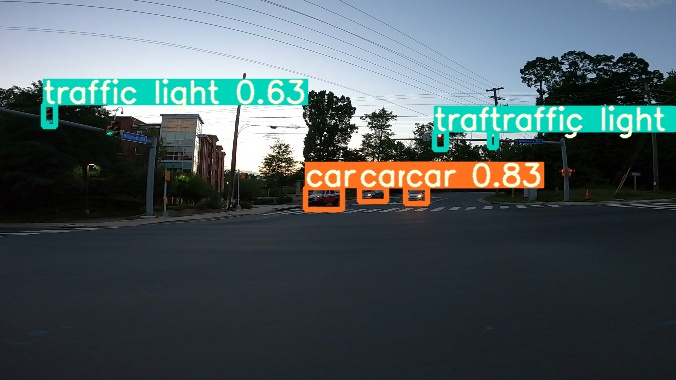

In [ ]:
Image(filename=f'runs/detect/exp/{random.choice(predicted_files)}')

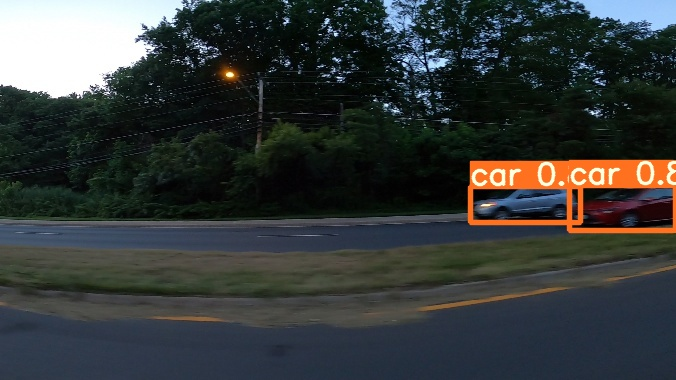

In [ ]:
Image(filename=f'runs/detect/exp/{random.choice(predicted_files)}')

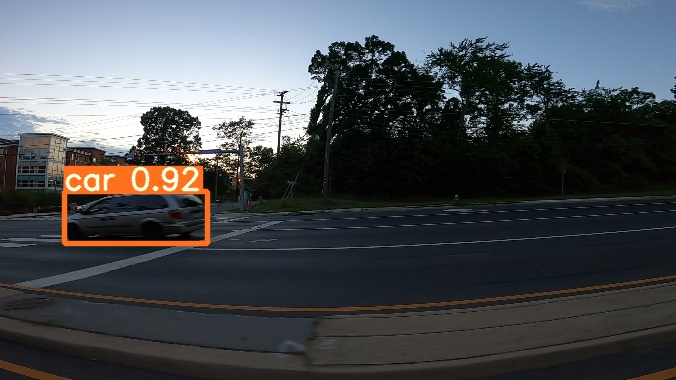

In [ ]:
Image(filename=f'runs/detect/exp/{random.choice(predicted_files)}')

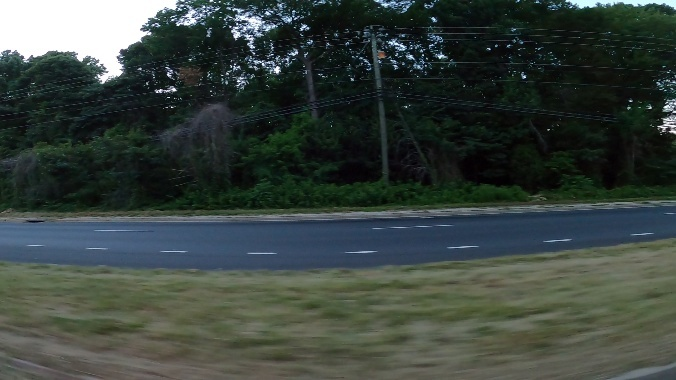

In [ ]:
Image(filename=f'runs/detect/exp/{random.choice(predicted_files)}')

In [ ]:
!rm -rf runs yolov5